In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings

from scipy import stats
from scipy.stats import norm

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn import linear_model, ensemble
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#set seaborn plot display options
sns.set(style='whitegrid', palette='muted', font_scale=1.3)

#color variables incase they're needed
color_b = sns.color_palette('muted').as_hex()[0]
color_g = sns.color_palette('muted').as_hex()[1]
color_r = sns.color_palette('muted').as_hex()[2]
color_p = sns.color_palette('muted').as_hex()[3]
color_y = sns.color_palette('muted').as_hex()[4]
color_c = sns.color_palette('muted').as_hex()[5]

# 0. Introduction

## 0.1 Research Proposal
- __Goal:__ predict house sale prices
- Why is this a good topic to study?
- What are some challenges to this topic?

## 0.2 Method
1. Develop & train a model to predict saleprice
2. Evaluation method: root mean squared error (RMSE) between the log of the predicted value and the log of the observed sales price
3. RMSE: absolute measure of fit, can compare across different models (r-squared is relative fit, increases as model complexity grows, so cannot compare across models)

# 1. Dataset: Ames, Iowa Housing Market Data

## 1.1 Dataset background

__Abstract Excerpt:__

This paper presents a data set describing the sale of individual residential property in Ames, Iowa from 2006 to 2010. The data set contains 2930 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values.

__Full Description:__

https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

__Data Source:__

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

Kaggle API: >_ kaggle competitions download -c house-prices-advanced-regression-techniques

## 1.2 Upload Data

In [3]:
train_raw = pd.read_csv('train.csv')
train_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# 2. EDA, Data Preprocessing, and Feature Selection/Engineering

## 2.1 Basic Cleaning

In [4]:
#set df to manipulate, leave raws accessible
train = train_raw.copy()

#lowercase column names
train.columns = [x.lower() for x in train.columns]

#strip whitespace
to_strip = train.select_dtypes(include='object')
train[to_strip.columns] = to_strip.apply(lambda x: x.str.strip())

## 2.2 Outliers

The [dataset documentation](https://ww2.amstat.org/publications/jse/v19n3/decock.pdf) points out a few problematic outliers, and recommends removing records where grlivarea > 4000

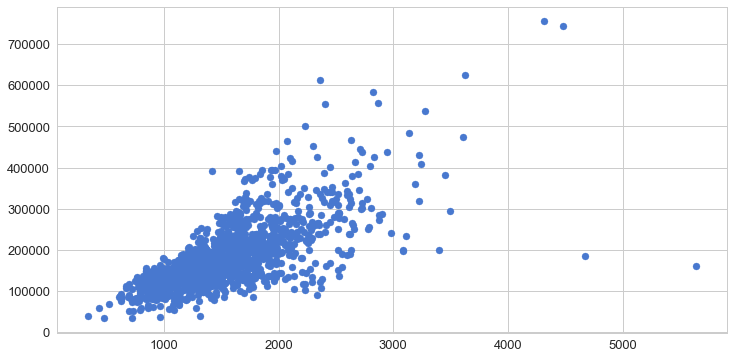

In [5]:
plt.figure(figsize=(12,6))
plt.scatter(train['grlivarea'], train['saleprice'])
plt.show()

In [6]:
train = train[train.grlivarea < 4000]
print(train.grlivarea.max())

3627


## 2.3 Missingness

In [7]:
#see whats missing
missing_data = train.isnull().sum().sort_values(ascending=False)
missing_data = missing_data.reset_index()
missing_data.columns = ['variable','rows_missing']
missing_data = missing_data[missing_data['rows_missing'] > 0]
missing_data

,variable,rows_missing
0,poolqc,1451
1,miscfeature,1402
2,alley,1365
3,fence,1176
4,fireplacequ,690
5,lotfrontage,259
6,garagecond,81
7,garagetype,81
8,garageyrblt,81
9,garagefinish,81


### Missing value handling: NA indicates lack of feature

- poolqc: pool quality
- miscfeature: miscellaneous feature not covered in other categories
- alley: type of alley access to property
- fence: fence quality
- fireplacequ: fireplace quality
- garagecond: garage condition
- garagetype: garage location
- garageyrblt: year garage was built
- garagefinish: interior finish of garage
- garagequal: garage quality
- bsmtexposure: refers to walkout or garden level walls
- bsmtfintype1: rating of basement finished area
- bsmtfintype2: rating of basement finished area (if multiple types)
- bsmtcond: evaluates the general condition of the basement
- bsmtqual: evaluates the height of the basement (in inches, Excellent >= 100, Poor < 70)
- masvnrtype: masonry veneer type
- masvnrarea: masonry veneer area in square feet

__Action:__ impute no_feature or 0 (descriptions are available in the 'data_description.txt' file)

In [8]:
#handle missing values, easy part
train['poolqc'].fillna('none', inplace=True)
train['miscfeature'].fillna('none', inplace=True)
train['alley'].fillna('none', inplace=True)
train['fence'].fillna('none', inplace=True)
train['fireplacequ'].fillna('none', inplace=True)
train['garagecond'].fillna('none', inplace=True) #consider revisiting
train['garagetype'].fillna('none', inplace=True)
train['garagefinish'].fillna('none', inplace=True)
train['garagequal'].fillna('none', inplace=True)
train['garageyrblt'].fillna(0, inplace=True)
train['bsmtexposure'].fillna('none', inplace=True)
train['bsmtfintype1'].fillna('none', inplace=True)
train['bsmtfintype2'].fillna('none', inplace=True)
train['bsmtcond'].fillna('none', inplace=True)
train['bsmtqual'].fillna('none', inplace=True)
train['masvnrtype'].fillna('none', inplace=True)
train['masvnrarea'].fillna(0, inplace=True)

### Missing value handling: electrical variable
electrical: electrical system, can be one of the following
- SBrkr: Standard Circuit Breakers & Romex
- FuseA: Fuse Box over 60 AMP and all Romex wiring (Average)	
- FuseF: 60 AMP Fuse Box and mostly Romex wiring (Fair)
- FuseP: 60 AMP Fuse Box and mostly knob elect & tube wiring (poor)
- Mix: Mixed

In [9]:
print(train['electrical'].value_counts(dropna=False))

SBrkr    1330
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: electrical, dtype: int64


In [10]:
#impute with most common value
train['electrical'].fillna('SBrkr', inplace=True)
print(train['electrical'].value_counts(dropna=False))

SBrkr    1331
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: electrical, dtype: int64


### Missing value handling: variable lotfrontage
lotfrontage: linear feet of street connected to property

In [11]:
print(train['lotfrontage'].value_counts(
    dropna=False).sort_values(ascending=False).head())

NaN      259
 60.0    143
 70.0     70
 80.0     69
 50.0     57
Name: lotfrontage, dtype: int64


Hard to believe that 259 residential properties were sold without connecting to a street
- check against street access
- check against lotarea
- come up with strategy to impute

In [12]:
print('street value counts:')
print(train['street'].value_counts(dropna=False))
print('\nlotarea null values: ')

print(train['lotarea'].isnull().sum())
#make sure there aren't unreasonably small lot sizes, could indicate data error
print('\nlotarea smallest lots')
print(train['lotarea'].value_counts(dropna=False).sort_index().head())

street value counts:
Pave    1450
Grvl       6
Name: street, dtype: int64

lotarea null values: 
0

lotarea smallest lots
1300    1
1477    1
1491    1
1526    1
1533    2
Name: lotarea, dtype: int64


- Variables street and lotarea have no missing values
- Since every record has some street access and lot square footage, lotfrontage nulls should be filled with something

Could simply impute the mean, but we can be more creative than that:
- investigate the relationship between lotfrontage and lotarea
- Use this proportion to estimate lotfrontage from lotarea

In [13]:
temp_df = train.loc[:, (train.columns).isin(['lotfrontage', 'lotarea'])]
temp_df['ratio'] = temp_df['lotfrontage'] / temp_df['lotarea']

print('lotfrontage:lotarea proportion:')
print('ratio mean: %.5f' % temp_df['ratio'].dropna().mean())
print('ratio median: %.5f' % temp_df['ratio'].dropna().median())
print('ratio mode: %.5f' % temp_df['ratio'].dropna().mode())

lotfrontage:lotarea proportion:
ratio mean: 0.00791
ratio median: 0.00771
ratio mode: 0.00833


- Mean, median, and mode are all about 0.008
- Impute lotfrontage nulls with their lotarea * mean ratio to estimate lotfrontage

In [14]:
ratio_mean = (train['lotfrontage'] / train['lotarea']).mean()
train['lotfrontage'].fillna(train['lotarea'] * ratio_mean, inplace=True)
train['lotfrontage'].isnull().sum()

0

## 2.4 Feature Engineering
__To do list:__
- Drop 'id' column, no helpful data, just record id numbers
- Numerical features that are actually categorical: mssubclass, mosold
- Currently mosold and yrsold are separate features, keep separate but also create new feature combining them
- Variables that appear categorical but are ordinal
    - See how logging later in the notebook handles these first
    - ¿ set scales equal across (ie max 10 for all) ?
    - ¿ standardscaler() ? 
- variable correlations:
    - corr with sale price
    - multicollinearity
    - create features/PCA as necessary

In [15]:
#drop id column
train = train.drop(['id'], 1)

In [16]:
#mssubclas to categorical
train = train.replace(
    {'mssubclass':{20:'subclasss20', 30:'subclass30', 40:'subclass40',
                   45:'subclass45', 50:'subclass50', 60:'subclass60',
                   70:'subclass70', 75:'subclass75', 80:'subclass80',
                   85:'subclass85', 90:'subclass90', 120:'subclass120',
                   150:'subclass150', 160:'subclass160', 180:'subclass180',
                   190:'subclass190'},
     'mosold':{1:'_01jan', 2:'_02feb', 3:'_03mar', 4:'_04apr', 5:'_05may',
               6:'_06jun', 7:'_07jul', 8:'_08aug', 9:'_09sep', 10:'_10oct',
               11:'_11nov', 12:'_12dec'}})

In [17]:
#create yr/mo sold feature
train['yrmo_sold'] = train.yrsold.astype(
    str).str.cat(train.mosold.astype(str)) #.astype(int)

In [18]:
#categorical to ordinal
train = train.replace(
    {'street':{'Grvl':1, 'Pave':2},
     'alley':{'none':0, 'Grvl':1, 'Pave':2},
     'utilities':{'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4},
     'exterqual':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'extercond':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'bsmtqual':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'bsmtcond':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'bsmtexposure':{'none':0, 'No':0, 'Mn':2, 'Av':3, 'Gd':4},
     'bsmtfintype1':{'none':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
     'bsmtfintype2':{'none':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':45, 'GLQ':6},
     'heatingqc':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'kitchenqual':{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'functional':{'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8},
     'fireplacequ':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'garagefinish':{'none':0, 'Unf':1, 'RFn':2, 'Fin':3},
     'garagequal':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'garagecond':{'none':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5},
     'paveddrive':{'N':1, 'P':2, 'Y':2},
     'poolqc':{'none':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}})

In [19]:
#possibly subjective
#separate so easy to include or exclude (comment out)
train = train.replace({'lotshape':{'IR3':1, 'IR2':2, 'IR1':3, 'Reg':4}})
train = train.replace({'landcontour':{'Low':1, 'HLS':2, 'Bnk':3, 'Lvl':4}})
#train = train.replace({'lotconfig':{}})
#train = train.replace({'landslope':{'Gtl':1, 'Mod':2, 'Sev':3}})
train = train.replace({'centralair':{'N':0, 'Y':1}})
#train = train.replace({'garagetype':{'none':0, 'CarPort':1, 'Detchd':2},
#                       'BuiltIn':3, 'Basment':4, 'Attchd':5, '2Types':6})

#maybe split this into 2 features
#train = train.replace('fenceqc':{'none':0, 'MnWw':1, 'GdWd':2, 'MnPrv'})

Look into:
- roofstyle
- roofmat1
- exterior1st
- exterior2nd
- masvnrtype
- foundation

In [20]:
#corrmat = train.corr()

#plt.figure(figsize=(12,12))
#sns.heatmap(corrmat, square=True)
#plt.show()

In [21]:
#feats_corr = corrmat['saleprice'].sort_values(ascending=False).tail(-1)
#feats_corr = feats_corr[feats_corr > 0.25]
#feats_corr

__Square footage variables:__ grlivarea, totalbsmtsf, garagearea, 1stflrsf, bsmtfinsf1, openporchsf, wooddecksf, 2ndflrsf, bsmtunfsf are all positively correlated with saleprice to different extents
- Drop garagearea: garagecars and garagearea say essentially the same thing, garagecars has higher correlation with saleprice and is a better measure of garage usefulness
- Check collinearity of sf variables, remove and/or create features as necessary

In [22]:
train = train.drop('garagearea', 1)

In [23]:
#even though its not in this list, include bsmtfinsf2 here
#sf_vars = train.loc[:, (train.columns).isin(['grlivarea', 'totalbsmtsf',
#                                             '1stflrsf', 'bsmtfinsf1',
#                                             'openporchsf', 'wooddecksf',
#                                             '2ndflrsf', 'bsmtunfsf',
#                                             'bsmtfinsf2'])]

#plt.figure(figsize=(12,12))
#sns.heatmap(sf_vars.corr(), square=True)
#plt.show()

In [24]:
#c = sf_vars.corr()
#s = c.unstack()
#so = pd.DataFrame(s.sort_values(ascending=False))
#so = so.reset_index()
#so.columns = ['var1', 'var2', 'corr']
#so = so[so['corr'] < 1]
#so = so[so['corr'] > 0.25]
#so.drop_duplicates(subset='corr', keep='first', inplace=True)
#so.sort_values(by='corr', ascending=False)

### New features to create:
- finished basement sf (bsmtfinsf1 + bsmtfinsf2)
- ~~¿ maybe finished basement (1) or not finished (0) based on totalbsmtsf vs. finished & unfinished~~ - this is covered under bsmtfintype variables
- PCA opportunity between grlivarea, 1stflrsf, 2ndflrsf, totalbsmtsf?

In [25]:
#first make sure current sf variables add up as expected
#print((train['bsmtfinsf1'] + train['bsmtfinsf2'] + train['bsmtunfsf'] == train['totalbsmtsf']).value_counts(dropna=False))
#print((train['1stflrsf'] + train['2ndflrsf'] + train['lowqualfinsf'] == train['grlivarea']).value_counts(dropna=False))

In [26]:
#create bsmtfinsf_total
train['bsmtfinsf_total'] = train['bsmtfinsf1'] + train['bsmtfinsf2']

#drop original bsmt columns
train = train.loc[:, ~(train.columns).isin(['bsmtfinsf1', 'bsmtfinsf2'])]

train.head()

,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,...,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,yrmo_sold,bsmtfinsf_total
0,subclass60,RL,65.0,8450,2,0,4,4,4,Inside,...,none,none,0,_02feb,2008,WD,Normal,208500,2008_02feb,706
1,subclasss20,RL,80.0,9600,2,0,4,4,4,FR2,...,none,none,0,_05may,2007,WD,Normal,181500,2007_05may,978
2,subclass60,RL,68.0,11250,2,0,3,4,4,Inside,...,none,none,0,_09sep,2008,WD,Normal,223500,2008_09sep,486
3,subclass70,RL,60.0,9550,2,0,3,4,4,Corner,...,none,none,0,_02feb,2006,WD,Abnorml,140000,2006_02feb,216
4,subclass60,RL,84.0,14260,2,0,3,4,4,FR2,...,none,none,0,_12dec,2008,WD,Normal,250000,2008_12dec,655


## 2.5 Variable Distributions

### Target Variable: saleprice

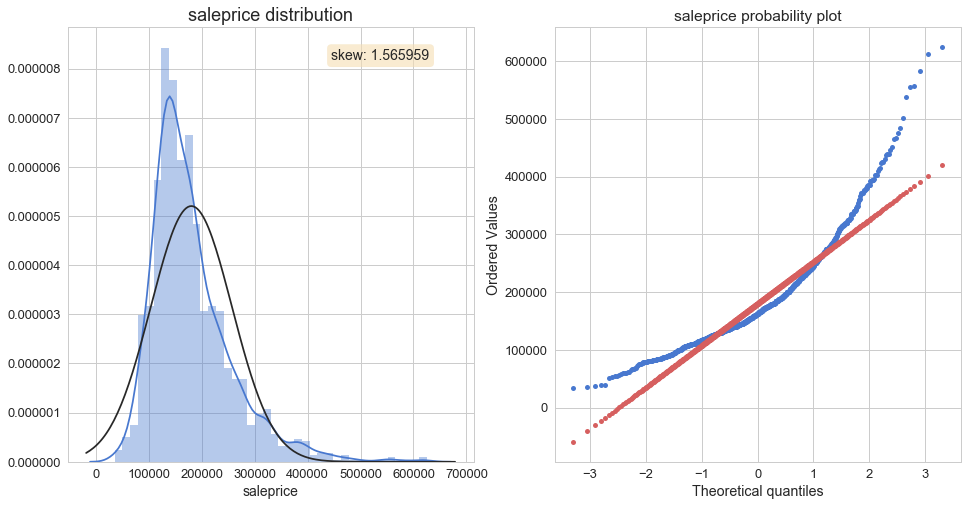

NormaltestResult(statistic=460.3067960010808, pvalue=1.1108342380647651e-100)


In [27]:
plt.figure(figsize=(16,8))

ax1 = plt.subplot(121)
sns.distplot(train['saleprice'], ax=ax1, fit=norm)
ax1.set_xlabel('saleprice', size=14)
ax1.set_title('saleprice distribution', size=18)
#text box
props = dict(boxstyle='round', color='wheat', alpha=.6)
textstr1 = 'skew: %f' % (train['saleprice'].skew())
ax1.text(0.65, 0.95, textstr1, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax2 = plt.subplot(122)
stats.probplot(train['saleprice'], plot=ax2)
ax2.set_title('saleprice probability plot')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_markerfacecolor(color_b)
ax2.get_lines()[0].set_markersize(10)
ax2.get_lines()[1].set_linewidth(0)
ax2.get_lines()[1].set_marker('.')
ax2.get_lines()[1].set_markerfacecolor(color_r)
ax2.get_lines()[1].set_markersize(10)

plt.show()
print(stats.normaltest(a=train['saleprice']))

- saleprice is pretty far from normally distributed
- See how log transformation looks

In [28]:
print('log:', stats.normaltest(a=np.log(train['saleprice'])))
print('log1p:', stats.normaltest(a=np.log1p(train['saleprice'])))

log: NormaltestResult(statistic=17.417871145375766, pvalue=0.0001651039020773473)
log1p: NormaltestResult(statistic=17.41764459169927, pvalue=0.00016512260558467428)


- Log transforming saleprice results in a much more normal distribution
- Both log & log1p give nearly identical resuls so I'll use log1p since it plays nicer with zero's and avoids a lot of potential '-inf' values (result of trying to log zero or negative)

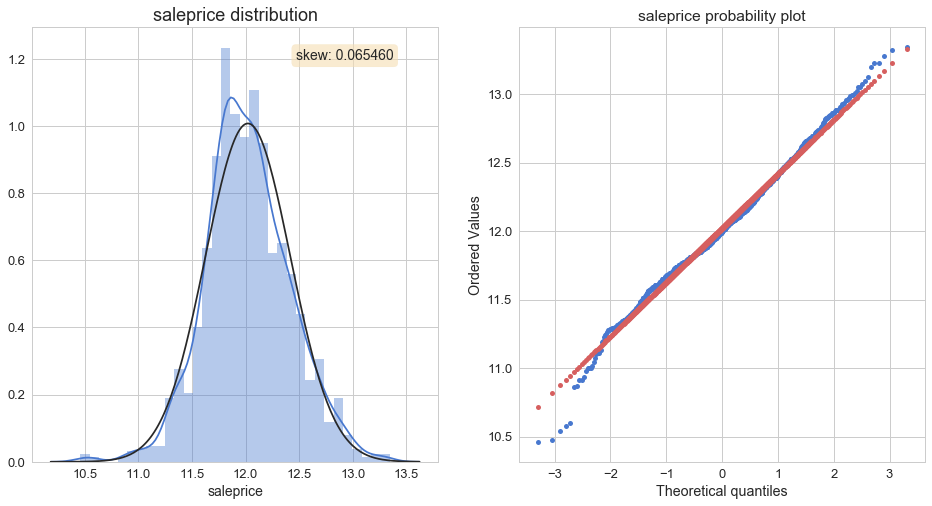

NormaltestResult(statistic=17.41764459169927, pvalue=0.00016512260558467428)


In [29]:
train['saleprice'] = np.log1p(train['saleprice'])

plt.figure(figsize=(16,8))

ax1 = plt.subplot(121)
sns.distplot(train['saleprice'], ax=ax1, fit=norm)
ax1.set_xlabel('saleprice', size=14)
ax1.set_title('saleprice distribution', size=18)
#text box
props = dict(boxstyle='round', color='wheat', alpha=.6)
textstr1 = 'skew: %f' % (train['saleprice'].skew())
ax1.text(0.65, 0.95, textstr1, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax2 = plt.subplot(122)
stats.probplot(train['saleprice'], plot=ax2)
ax2.set_title('saleprice probability plot')
ax2.get_lines()[0].set_marker('.')
ax2.get_lines()[0].set_markerfacecolor(color_b)
ax2.get_lines()[0].set_markersize(10)
ax2.get_lines()[1].set_linewidth(0)
ax2.get_lines()[1].set_marker('.')
ax2.get_lines()[1].set_markerfacecolor(color_r)
ax2.get_lines()[1].set_markersize(10)

plt.show()
print(stats.normaltest(a=train['saleprice']))

### Further transformations
#### Numeric Variables
Since target variable saleprice has been log-transformed, model interpretability gets a little complicated unless other numeric features are log-transformed as well.
- Not basing this on a skew threshold since regression doesn't care how independent variables are distributed
- Coefficients can be interpreted as 'a x% change in beta x_i results in a y% change in y_i' (as long as the features in question have been log transformed)
- Added benefit of reducing the effect of outliers

In [30]:
numeric_feats = train.dtypes[train.dtypes != 'object'].index
numeric_feats = numeric_feats.tolist()
numeric_feats.remove('saleprice')
#print('saleprice' in numeric_feats)
#print(len(numeric_feats))

to_scale = train[numeric_feats]
scaler = StandardScaler()

In [31]:
error

NameError: name 'error' is not defined

In [ ]:
#skewed_feats = []
#skewed_feats_dict = {}
#outside_thresh_dict = {}

#for feat in numeric_feats:
#    if train[feat].skew() >= 0.5 or train[feat].skew() <= -0.5:
#        skewed_feats.append(feat)
#        skewed_feats_dict[feat] = train[feat].skew()
#    else:
#        outside_thresh_dict[feat] = train[feat].skew()

In [ ]:
#print(len(skewed_feats), len(skewed_feats_dict), len(outside_thresh))
#print(skewed_feats_dict)
#print(outside_thresh)

In [ ]:
#train[skewed_feats] = np.log1p(train[skewed_feats])

In [ ]:
#skewed_feats_log1p = {}

#for feat in skewed_feats:
#    skewed_feats_log1p[feat] = train[feat].skew() 

#print(skewed_feats_log1p)

# LOG CELL

In [ ]:
#train[numeric_feats] = np.log1p(train[numeric_feats])

# LOG -> SCALER

In [ ]:
#train[numeric_feats] = np.log1p(train[numeric_feats])
#scaler.fit(to_scale.values)

# SCALER CELL

In [32]:
scaler.fit(to_scale.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

# SCALER -> LOG

In [43]:
#scaler.fit(to_scale.values)
train[numeric_feats] = np.log1p(train[numeric_feats])

## 2.6 Feature Selection

In [44]:
#create dummies and data/target
train = pd.get_dummies(train)
X = train.loc[:, ~(train.columns).isin(['saleprice'])]
y = train['saleprice']

#rmse evaluation function
cv = 5

def rmse(model):
    rmse = np.sqrt(-cross_val_score(
        model, X, y, cv=cv, scoring='neg_mean_squared_error'))
    return(rmse)

### Use Lasso/L1 regularization for feature selection

In [45]:
lasso = LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1,
                        0.0005, 0.005, 0.05, 0.5, 5]).fit(X, y)
alpha = lasso.alpha_
print('model: lasso')
print('alpha:', alpha)
print('rmse score mean:', rmse(lasso).mean())
print('rmse max - rmse min:', rmse(lasso).max() - rmse(lasso).min())
print('rmse score array:', rmse(lasso))

model: lasso
alpha: 0.0005
rmse score mean: 0.11703016993030299
rmse max - rmse min: 0.01677878442294968
rmse score array: [0.10718829 0.12128999 0.12396708 0.11491778 0.11778771]


In [ ]:
#lasso = LassoCV(alphas=[alpha, alpha*0.25, alpha*0.5, alpha*0.75,
#                        alpha*1.25, alpha*1.5, alpha*1.75, alpha*2]).fit(X, y)
#alpha = lasso.alpha_
#print('model: lasso')
#print('alpha: ', alpha)
#print('rmse score mean:', rmse(lasso).mean())
#print('rmse max - rmse min:', rmse(lasso).max() - rmse(lasso).min())
#print('rmse score array:', rmse(lasso))

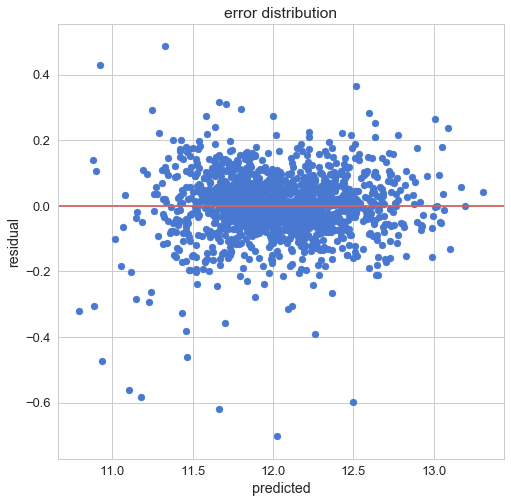

In [36]:
#check residual distribution
predicted = lasso.predict(X)
actual = y
residual = actual - predicted

plt.figure(figsize=(8,8))
plt.scatter(predicted, residual)
plt.axhline(y=0, color=color_r)
plt.xlabel('predicted')
plt.ylabel('residual')
plt.title('error distribution')
plt.show()

In [46]:
coefs = pd.Series(lasso.coef_, index=X.columns)
n_components = sum(coefs != 0)
print('lasso n_components: ', n_components)

features = pd.DataFrame(lasso.coef_, index=X.columns)
features = features.reset_index()
features.columns = ['var','coef']
features = features[features['coef'] != 0]
features = list(features['var'])

X = X[features]

lasso n_components:  110


# Modeling

### Linear Regression with L2/Ridge Regularization

In [47]:
ridge = RidgeCV(
    alphas=[0.01, 0.05, 0.1, 0.5, 1, 5]
).fit(X, y)

alpha = ridge.alpha_
print('model: ridge')
print('alpha:', alpha)
print('rmse score mean:', rmse(ridge).mean())
print('rmse max - rmse min:', rmse(ridge).max() - rmse(ridge).min())
print('rmse score array:', rmse(ridge))

model: ridge
alpha: 1.0
rmse score mean: 0.1136438527740862
rmse max - rmse min: 0.01598796551136822
rmse score array: [0.10340799 0.11743241 0.11939596 0.11032307 0.11765983]


In [48]:
ridge = RidgeCV(
    alphas=[alpha, alpha*0.25, alpha*0.5, alpha*0.75,
            alpha*1.25, alpha*1.5, alpha*1.75, alpha*2]
).fit(X, y)
alpha = ridge.alpha_
print('model: ridge')
print('alpha:', alpha)
print('cross_val rmse mean:', rmse(ridge).mean())
print('rmse max - rmse min:', rmse(ridge).max() - rmse(ridge).min())
print('rmse score array:', rmse(ridge))

model: ridge
alpha: 2.0
cross_val rmse mean: 0.11349154486341295
rmse max - rmse min: 0.015335099076811146
rmse score array: [0.10379719 0.11739792 0.11913229 0.1102532  0.11687713]


### Linear Regression with L1/Lasso Regularization

In [49]:
lasso = LassoCV(
    alphas=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5,1, 5]
).fit(X, y)
alpha = lasso.alpha_
print('model: lasso')
print('alpha: ', alpha)
print('rmse score mean:', rmse(lasso).mean())
print('rmse max - rmse min:', rmse(lasso).max() - rmse(lasso).min())
print('rmse score array:', rmse(lasso))

model: lasso
alpha:  0.0001
rmse score mean: 0.11473480698859259
rmse max - rmse min: 0.014917030578185608
rmse score array: [0.10569735 0.12061438 0.11909957 0.1107268  0.11753594]


In [50]:
lasso = LassoCV(alphas=[alpha,
                        alpha*0.25, alpha*0.5, alpha*0.75,
                        alpha*1.25, alpha*1.5, alpha*1.75, alpha*2])

lasso.fit(X, y)
alpha = lasso.alpha_
print('model: lasso')
print('alpha: ', alpha)
print('rmse score mean:', rmse(lasso).mean())
print('rmse max - rmse min:', rmse(lasso).max() - rmse(lasso).min())
print('rmse score array:', rmse(lasso))

model: lasso
alpha:  0.000175
rmse score mean: 0.1137900380295421
rmse max - rmse min: 0.015815417599623557
rmse score array: [0.10358555 0.11852917 0.11940097 0.11084975 0.11658475]


### Random Forest Regressor

In [ ]:
rfr = ensemble.RandomForestRegressor()
params = [{'n_estimators':[10, 50, 100, 250, 500],
           'max_features':[1, int(n_components/2), n_components],
           'max_depth':[10,20,30,40]}]

start_time = time.clock()
grid = GridSearchCV(
    estimator=rfr,
    param_grid=params,
    scoring='neg_mean_squared_error'
).fit(X,y)

print('params:', grid.best_params_)
print('runtime: ', time.clock() - start_time)

In [ ]:
n_estimators = grid.best_params_.get('n_estimators')
max_depth = grid.best_params_.get('max_depth')
max_features = grid.best_params_.get('max_features')

start_time = time.clock()
rfr = ensemble.RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    max_features=max_features
).fit(X, y)

print('model: random forest')
print('rmse score mean:', rmse(rfr).mean())
print('rmse max - rmse min:', rmse(rfr).max() - rmse(rfr).min())
print('rmse score array:', rmse(rfr))
print('runtime: ', time.clock() - start_time)

### Support Vector Regressor

In [ ]:
#svr = SVR()
#params = [{'C':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 1, 5, 10],
#           'kernel':['linear']}]

#start_time = time.clock()
#grid = GridSearchCV(
#    estimator=svr,
#    param_grid=params,
#    scoring='neg_mean_squared_error'
#).fit(X, y)

#print('params:', grid.best_params_)
#print('runtime: ', time.clock() - start_time)

In [ ]:
#c = grid.best_params_.get('C')
#start_time = time.clock()
#svr = SVR(C=c, kernel='linear').fit(X, y)

#print('model: support vector')
#print('cross_val rmse mean:', rmse(svr).mean())
#print('rmse max - rmse min:', rmse(svr).max() - rmse(svr).min())
#print('rmse score array:', rmse(svr))
#print('runtime: ', time.clock() - start_time

## XGBoost Regressor

### Vanilla XGB

In [51]:
start_time = time.clock()
xgbr = XGBRegressor().fit(X, y)
print('model: vanilla xgb_rgr')
print('cross_val rmse mean:', rmse(xgbr).mean())
print('rmse max - rmse min:', rmse(xgbr).max() - rmse(xgbr).min())
print('rmse score array:', rmse(xgbr))
print('runtime: ', time.clock() - start_time)

model: vanilla xgb_rgr
cross_val rmse mean: 0.12207484376657096
rmse max - rmse min: 0.011202216556718811
rmse score array: [0.11514714 0.12634936 0.12556426 0.12195982 0.12135365]
runtime:  4.266137999999998


In [52]:
start_time = time.clock()
xgbr = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05
).fit(X, y, verbose=False)

print('model: vanilla xgb_rgr')
print('cross_val rmse mean:', rmse(xgbr).mean())
print('rmse max - rmse min:', rmse(xgbr).max() - rmse(xgbr).min())
print('rmse score array:', rmse(xgbr))
print('runtime: ', time.clock() - start_time)

model: vanilla xgb_rgr
cross_val rmse mean: 0.11524706838191645
rmse max - rmse min: 0.014179452516408425
rmse score array: [0.10674448 0.12092393 0.11990284 0.11344396 0.11522013]
runtime:  42.777578000000005


### Tune Parameters

In [ ]:
xgbr = XGBRegressor()
params = [{'booster':['gbtree', 'gblinear'],
           'max_depth':[2, 3, 5, 10],
           'learning_rate':[0.1, 0.05, 0.01],
           'subsample':[0.25, 0.5, 0.75, 1]}]

start_time = time.clock()
grid = GridSearchCV(
    estimator=xgbr,
    param_grid=params,
    scoring='neg_mean_squared_error'
).fit(X,y)

print('params:', grid.best_params_)
print('runtime: ', time.clock() - start_time)

In [ ]:
booster = grid.best_params_.get('booster')
learning_rate = grid.best_params_.get('learning_rate')
max_depth = grid.best_params_.get('max_depth')
subsample = grid.best_params_.get('subsample')

start_time = time.clock()
xgb_rgr = XGBRegressor(
    n_estimators=1000,
    learning_rate=learning_rate,
    max_depth=max_depth,
    subsample=subsample
).fit(X, y, verbose=False)
#xgb_rgr.fit(X_train, y_train, early_stopping_rounds=5,
#            eval_set=[(X_test, y_test)], verbose=False)

print('model: xgboost regressor')
print('cross_val rmse mean:', rmse(xgbr).mean())
print('rmse max - rmse min:', rmse(xgbr).max() - rmse(xgbr).min())
print('rmse score array:', rmse(xgbr))
print('runtime: ', time.clock() - start_time)